<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Practice MLR using the Sacramento Real Estate Data

_Authors: Joseph Nelson (DC), Matt Brems (DC)_

---

We return to the Sacramento real estate data, but this time around we will be constructing multiple linear regression models. 

You will review the assumptions of multiple linear regression and practice building a model using the statsmodels package.

### 1. Load the data. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [3]:
shd_csv = '../data/sacramento.csv'
shd=pd.read_csv(shd_csv)

In [4]:
# convert the date variable, as we did in the previous lab
shd.sale_date=pd.to_datetime(shd.sale_date)

## Feature engineering: sale date

In [5]:
# Describe sale date
shd.sale_date.describe()

count                           984
unique                            5
top       2008-05-19 00:00:00-04:00
freq                            268
first     2008-05-15 00:00:00-04:00
last      2008-05-21 00:00:00-04:00
Name: sale_date, dtype: object

In [6]:
# Convert sale date to a continuous variable.
shd['days_on_market']=shd['sale_date']-shd['sale_date'].min()
shd['days_on_market']=shd['days_on_market'].apply(lambda x: x.days)
shd['days_on_market'].describe()

count    984.000000
mean       3.219512
std        2.131149
min        0.000000
25%        1.000000
50%        4.000000
75%        5.000000
max        6.000000
Name: days_on_market, dtype: float64

## Feature engineering: Dummy Variables

It is important to be cautious with categorical variables, those that represent distict groups or categories, when building a regression. If put in a regression "as-is", categorical variables represented as integers will be treated like *continuous* variables.

That is to say, instead of group "3" having a different effect on the estimation than group "1" it will estimate literally 3 times more than group 1. 

For example, if occupation category "1" represents "analyst" and occupation category "3" represents "barista", and our target variable is salary, if we leave this as a column of integers then barista will always have `beta*3` the effect of analyst.

This will almost certainly force the beta coefficient to be something strange and incorrect. Instead, we can re-represent the categories as multiple "dummy coded" columns.


In [7]:
# What are the most frequent cities?
shd.city.value_counts().head()

SACRAMENTO        438
ELK GROVE         114
LINCOLN            72
ROSEVILLE          48
CITRUS HEIGHTS     35
Name: city, dtype: int64

In [8]:
# Let's create some "dummies" for the top 2.

shd['Sacramento'] = np.where(shd['city']=='SACRAMENTO', 1, 0)
shd['Elk_Grove'] = np.where(shd['city']=='ELK GROVE', 1, 0)
shd['Lincoln'] = np.where(shd['city']=='LINCOLN', 1, 0)

In [9]:
# What are the most frequent zip codes?
shd.zip.value_counts().head()

95648    72
95823    61
95828    45
95758    44
95838    37
Name: zip, dtype: int64

In [10]:
# Let's create some "dummies" for the top 2.
shd['Zip_95648'] = np.where(shd['zip']==95648, 1, 0)
shd['Zip_95823'] = np.where(shd['zip']==95823, 1, 0)

In [11]:
# How do those dummies look?
shd['Lincoln'].value_counts()

0    912
1     72
Name: Lincoln, dtype: int64

###  Use the `pd.get_dummies` function to convert the `type` column into dummy-coded variables.

Print out the header of the dummy-coded variable output.

In [12]:
print(shd.type.value_counts())
print(shd.dtypes)

Residential     917
Condo            53
Multi-Family     13
Unkown            1
Name: type, dtype: int64
Unnamed: 0                                         int64
street                                            object
city                                              object
zip                                                int64
state                                             object
beds                                               int64
baths                                              int64
sq__ft                                             int64
type                                              object
sale_date         datetime64[ns, pytz.FixedOffset(-240)]
price                                              int64
latitude                                         float64
longitude                                        float64
days_on_market                                     int64
Sacramento                                         int64
Elk_Grove                               

In [13]:
pd.get_dummies(shd.type).head()

,Condo,Multi-Family,Residential,Unkown
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


In [14]:
shd2=pd.get_dummies(shd, columns = ['type'])
print(shd.columns)
shd2.head(3)

Index(['Unnamed: 0', 'street', 'city', 'zip', 'state', 'beds', 'baths',
       'sq__ft', 'type', 'sale_date', 'price', 'latitude', 'longitude',
       'days_on_market', 'Sacramento', 'Elk_Grove', 'Lincoln', 'Zip_95648',
       'Zip_95823'],
      dtype='object')


,Unnamed: 0,street,city,zip,state,beds,baths,sq__ft,sale_date,price,...,days_on_market,Sacramento,Elk_Grove,Lincoln,Zip_95648,Zip_95823,type_Condo,type_Multi-Family,type_Residential,type_Unkown
0,0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,2008-05-21 00:00:00-04:00,59222,...,6,1,0,0,0,0,0,0,1,0
1,1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,2008-05-21 00:00:00-04:00,68212,...,6,1,0,0,0,1,0,0,1,0
2,2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,2008-05-21 00:00:00-04:00,68880,...,6,1,0,0,0,0,0,0,1,0


---

### A caution with dummy-coding

Let's touch on a caution moving forward and interpreting these.

**If you convert a qualitative variable to dummy variables, you want to turn a variable with N categories into N-1 variables.**

> Scenario 1: Suppose we're working with the variable "sex" or "gender" with values "M" and "F". 

You should include in your model only one variable for "sex = F" which takes on 1 if sex is female and 0 if sex is not female! Rather than saying "a one unit change in X," the coefficient associated with "sex = F" is interpreted as the average change in Y when sex = F relative to when sex = M.

> Scenario 2: Suppose we're modeling revenue at a bar for each of the days of the week. We have a column with strings identifying which day of the week this observation occured in.

We might include six of the days as their own variables: "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday". **But not all 7 days.**

The coefficient for Monday is then interpreted as the average change in revenue when "day = Monday" relative to "day = Sunday." The coefficient for Tuesday is interpreted in the average change in revenue when "day = Tuesday" relative to "day = Sunday" and so on.

The category you leave out, which the other columns are *relative to* is often referred to as the **reference category**.

### 3. Remove "Unkown" from your dummy coded variable dataframe and append the rest to the original data.

In [15]:
# A: I don't need to append, because I wrote it into a new dataset "shd2".
shd2.drop('type_Unkown', axis=1, inplace=True)

### 4. Build what you think may be the best MLR model predicting `price`. 

The independent variables are your choice, but *include at least three variables.* At least one of which should be a dummy-coded variable (either one we created before or a new one).

You may use either `sklearn` or `statsmodels` to do this.

In [16]:
shd2.columns

Index(['Unnamed: 0', 'street', 'city', 'zip', 'state', 'beds', 'baths',
       'sq__ft', 'sale_date', 'price', 'latitude', 'longitude',
       'days_on_market', 'Sacramento', 'Elk_Grove', 'Lincoln', 'Zip_95648',
       'Zip_95823', 'type_Condo', 'type_Multi-Family', 'type_Residential'],
      dtype='object')

In [17]:
# A: my predictors are square feet, bedrooms, and Residential type
X = shd2[['sq__ft', 'beds', 'baths', 'type_Residential', 
          'type_Multi-Family',  'latitude', 'longitude',
          'Lincoln', 'Sacramento', 'Elk_Grove', 'days_on_market', 
          'Zip_95648', 'Zip_95823']]
y= shd2['price']

In [18]:
# Let's take a look at that.
print(type(X))
X.head()

<class 'pandas.core.frame.DataFrame'>


,sq__ft,beds,baths,type_Residential,type_Multi-Family,latitude,longitude,Lincoln,Sacramento,Elk_Grove,days_on_market,Zip_95648,Zip_95823
0,836,2,1,1,0,38.631913,-121.434879,0,1,0,6,0,0
1,1167,3,1,1,0,38.478902,-121.431028,0,1,0,6,0,1
2,796,2,1,1,0,38.618305,-121.443839,0,1,0,6,0,0
3,852,2,1,1,0,38.616835,-121.439146,0,1,0,6,0,0
4,797,2,1,1,0,38.519470,-121.435768,0,1,0,6,0,0


In [19]:
# and the target variable (price)
print(type(y))
y.head()

<class 'pandas.core.series.Series'>


0    59222
1    68212
2    68880
3    69307
4    81900
Name: price, dtype: int64

### 5. Train-test Split
Use model_selection.train_test_split from sklearn to split the data into training and testing sets. Set test_size=0.3 and random_state=101

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [21]:
# Confirm that the lengths are what you expect.
print(len(shd2))
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

984
688
688
296
296


### 6. Fit your model on the training data.

In [22]:
# instantiate the sklearn regression class and fit it to your training data.

linreg = LinearRegression()
linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [23]:
# Display the coefficients.
coeffs = list(zip(X.columns, linreg.coef_))
for i in coeffs:
    print(i[0], ': ', round(i[1], 2))
print('intercept:', round (linreg.intercept_, 2))

sq__ft :  26.65
beds :  -13013.79
baths :  50115.54
type_Residential :  70467.12
type_Multi-Family :  -11533.76
latitude :  88409.56
longitude :  238432.43
Lincoln :  -71661.37
Sacramento :  -29893.62
Elk_Grove :  14447.97
days_on_market :  2878.81
Zip_95648 :  -71661.37
Zip_95823 :  -31743.81
intercept: 25619140.98


In [24]:
# predict the y-values
y_pred = linreg.predict(X_test)
for i in y_pred[:5]:
    print(round(i,0))

237234.0
315819.0
212837.0
255647.0
211483.0


In [25]:
# How similar are those to the actual home prices?
for i in y_test[:5]:
    print(round(i,0))

190000
600000
263500
285000
261000


In [26]:
# the residuals are the difference between true y values and predicted y values.
residuals= y_test - y_pred
for i in residuals[:5]:
    print(round(i,0))

-47234.0
284181.0
50663.0
29353.0
49517.0


### 5. Plot the residuals against the true points to evaluate your MLR visually.

> **Tip:** with seaborn's `sns.lmplot` you can set `x`, `y`, and even a `hue` (which will plot regression lines by category in different colors) to easily plot a regression line.

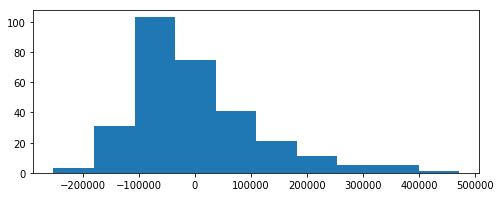

In [27]:
# Plot the distribution of our residuals (remember: zero is good!!)
plt.figure(figsize=(8, 3))
plt.hist(residuals);

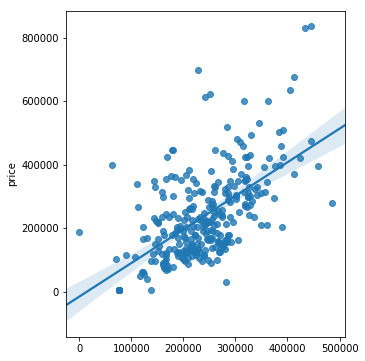

In [28]:
# Use a scatter plot to compare our predictions to the actual values
# Remember: when x==y, that indicates an accurate model! 
# Do we have that?
plt.figure(figsize=(5, 6))
sns.regplot(y_pred, y_test);

### 6. Evaluate your model

Let's evaluate our model performance by calculating the residual sum of squares and the explained variance score (R^2).

#### Calculate the Root Mean Squared Error (RMSE)

In [29]:
from math import sqrt
# On average, by how much value are we missing the mark?
rmse = sqrt(metrics.mean_squared_error(y_test, y_pred))
print('On average, our model errs by $', round(rmse))

On average, our model errs by $ 111189


In [38]:
# So... what if we just flipped a coin?
avg_val=round(y_train.mean())
print('The average price of a house is $', avg_val)

# Then the average error of our model would be:
comparison_array=np.full((len(y_test), ), avg_val)
coin_flip=sqrt(metrics.mean_squared_error(y_test, comparison_array))
print('If we just used that to predict price, our avg error would be:')
print('$',round(coin_flip))

The average price of a house is $ 233020
If we just used that to predict price, our avg error would be:
$ 139624


In [31]:
# So is our model better than flipping a coin?
print('A good model will reduce error!')
print('$', round(rmse-coin_flip))

A good model will reduce error!
$ -28408


#### Calculate the R-square score

In [32]:
# A higher score indicates more variance explained.
r2=metrics.r2_score(y_test, y_pred)
round(r2,2)

0.37

### List the five assumptions for an MLR model. 

Indicate which ones are the same as the assumptions for an SLR model. 

Simple linear regression has four assumptions:
1. **Linearity:** $Y$ must have an approximately linear relationship with each independent $X_i$.
2. **Independence:** Errors (residuals) $\epsilon_i$ and $\epsilon_j$ must be independent of one another for any $i \ne j$.
3. **Normality:** The errors (residuals) follow a Normal distribution.
4. **Equality of Variances**: The errors (residuals) should have a roughly consistent pattern, regardless of the value of the $X_i$ predictors. (There should be no discernable relationship between the $X$ predictors and the residuals.)

Multiple linear regression adds a fifth assumption:
5. **Independence of Predictors**: The independent variables $X_i$ and $X_j$ must be independent of one another for any $i \ne j$.

###  Pick at least two assumptions and articulate whether or not you believe them to be met  for your model and why.

In [33]:
# Normality: The errors (residuals) follow a Normal distribution, as demonstrated by the histogram above.
# Independence of Predictors: It's very unlikely that the 3 variables I picked 
# ('sq__ft', 'beds', 'type_Residential') are in highly correlated with each other.
# Just because it's a residential house doesn't mean it has more bedrooms or larger square
# footage than a townhouse or condo.

### Explain what the intercept in your model means in the context of your predictor variables.

In [34]:
# A: My intercept is $88,468. 
# For a house that has zero bedrooms and zero square footage, and is non-residential
# we would expect the sale price to be about $88K. Adding more square footage, bathrooms, or 
# residential status would increase the price from that baseline.
print('intercept= $',round(linreg.intercept_))

intercept= $ 25619141.0
